In [8]:
import os, sys
import warnings
warnings.filterwarnings('ignore')
from cellProcessing_single_WS import *
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# dir_root = '/nrs/ahrens/jing/giving_up/20190430/fish01/6dpf_HuC-GCaMP7ff-GFAP-RGECO_GU-slow-fwd_fish01_exp01_20190430_174349/im'
# save_root = '/nrs/ahrens/Ziqiang/Jing_Glia_project/Processed_data/20190430/fish01/6dpf_HuC-GCaMP7ff-GFAP-RGECO_GU-slow-fwd_fish01_exp01_20190430_174349/'

dir_root = '/nrs/ahrens/jing/giving_up/20190426/fish03/7dpf_HuC-H2B_GCaMP7ff_GU-slow-fwd_fish03_exp02_20190426_221213/im'
save_root = '/nrs/ahrens/Ziqiang/Jing_Glia_project/Processed_data/20190426/fish03/7dpf_HuC-H2B_GCaMP7ff_GU-slow-fwd_fish03_exp02_20190426_221213/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
dask_tmp = '/opt/data/weiz/dask-worker-space'
memory_limit = 0 # unlimited

if not os.path.exists(save_root):
    os.makedirs(save_root)

nsplit = (16, 32)
baseline_percentile = 20
baseline_window = 1000   # number of frames
cameraNoiseMat = '/nrs/ahrens/ahrenslab/Ziqiang/gainMat/gainMat20180208'

In [10]:
# default_mask(dir_root, save_root, dask_tmp=dask_tmp, memory_limit=memory_limit)

In [11]:
# Y_d = da.from_zarr(f'{save_root}/Y_ave.zarr')
# np.save(f'{save_root}/Y_ave', Y_d.compute())
Y_d = np.load(f'{save_root}/Y_ave.npy')
Y_d_max = Y_d.max(axis=0, keepdims=True)

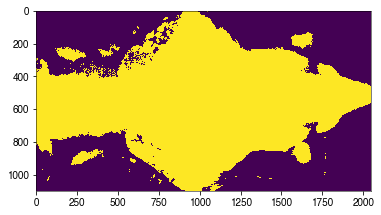

In [14]:
max_ = np.percentile(Y_d_max, 45)
mask_ = Y_d_max>max_
mask_ = np.repeat(mask_, Y_d.shape[0], axis=0)
mask_ = da.from_array(mask_, chunks=(1, Y_d.shape[1]//nsplit[0], Y_d.shape[2]//nsplit[1], -1))
plt.imshow(mask_[0].squeeze())
plt.show()

In [6]:
mask_

,Array,Chunk
Bytes,47.65 MB,4.42 kB
Shape,"(21, 1108, 2048, 1)","(1, 69, 64, 1)"
Count,11425 Tasks,11424 Chunks
Type,bool,numpy.ndarray


In [ ]:
print('========================')
print('DF/F computation')
compute_cell_dff_raw(save_root, mask_, dask_tmp=dask_tmp, memory_limit=0)
combine_dff(save_root)
combine_dff_sparse(save_root)

DF/F computation
Scheduler: inproc://10.150.100.212/213338/1
Dashboard link: http://10.150.100.212/213338/1:8787/status
